# Model Development

**Note: This notebook is a continuation of the exploratory_data_analysis notebook. For more information on that topic. please feel free to look at exploratory_data_analysis.ipynb** 

After exploring and analyzing the music dataset, we hypothesized that the best model that can classify a song's or music track's genre will be the convolutional neural network. To justify why it might be the best choice for our supervised learning problem, let's take a look at an example mel-spectrogram.

<center><img src="example_mel-spectrogram.png" style="width:600px;height:450px"></center>

As you can see in this image,
* There are multiple squiggly lines at the lower segment of the image so it indicates that there is a vocalist in the music track.
* There are many bright vertical lines that is consistently spaced so it means that the music track has a consistent beat.

If the mel-spectrogram was shifted slightly to the left by one pixel, then intuitively, it looks like the same mel-spectrogram. Hence, if the shifted mel-spectrogram was translated to an audio file, then it would sound the same as the original. This means that if we need a model that can identify a track's genre, then it must be translationally invariant. Fortunately, the convolutional neural network model is designed to be translationally invariant because it inherently uses a filter that passes through an image to perform a convolutional operation. Fore more details about CNNs, see https://en.wikipedia.org/wiki/Convolutional_neural_network.

Before we can use CNNs to classify a song's genre, we first need to preprocess our music dataset so that it can be easily used as input for our model.

#### Preprocessing Phase

In [1]:
import numpy as np
import pandas as pd

from librosa import load, power_to_db
from librosa.feature import melspectrogram

def compute_melspectrogram(file_location):
    y, sampling_rate = load(file_location)
    melspectrogram_db = power_to_db(
        melspectrogram(y=y, sr=sampling_rate), 
        ref=np.max
    )

    return melspectrogram_db

#One Hot Encode The Genres
music_df = pd.read_csv('../data/metadata.csv')
genre_df = pd.get_dummies(music_df.genre, prefix='is-')

music_df = music_df.join(genre_df)
music_df.drop(['genre'], axis=1, inplace=True)

#Convert File Locations To Melspectrograms
music_df["melspectrograms"] = music_df["file_location"].apply(compute_melspectrogram)
music_df.drop(['file_location'], axis=1, inplace=True)

#Save Predictor Variables As Numpy Arrays
melspectrograms = np.array(
    list(music_df['melspectrograms'])
)
extracted_features = np.array(
    music_df[['tempo', 'zero_crossing_rate', 'average_spectral_flatness']]
)

np.save('melspectrograms.npy', melspectrograms)
np.save('extracted_features.npy', extracted_features)

#Save Response Variables As Numpy Arrays
one_hot_encoded_genres = np.array(genre_df)
np.save('one_hot_encoded_genres.npy', one_hot_encoded_genres)

#### Load Data (Run Once After Running Above Cell)

In [1]:
import numpy as np

melspectrograms = np.load('melspectrograms.npy')
melspectrograms = melspectrograms.reshape(
    *melspectrograms.shape, 
    1
)

extracted_features = np.load('extracted_features.npy')
extracted_features = extracted_features.reshape(
    *extracted_features.shape, 
    1
)

one_hot_encoded_genres = np.load('one_hot_encoded_genres.npy')

#### Import Necessary TensorFlow Modules + Useful Functions

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk_metrics
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

def confusion_plot(actuals, predictions):
    test_labels = actuals.argmax(axis=1)
    pred_labels = predictions.argmax(axis=1)
    confusion = sk_metrics.confusion_matrix(test_labels, pred_labels)
    confusion = confusion.astype("float") / confusion.sum(axis=1).reshape(-1,1)
    
    labels = ['hip-hop', 'jazz', 'pop', 'rock', 'soundtrack']
    df_cm = pd.DataFrame(confusion, index=labels, columns=labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws = {"size": 16})
    plt.show()
    
def plot_training_curves(train_log):
    fig = plt.figure(figsize=(20, 6))
    
    epochs = len(train_log.history['accuracy'])

    plt.subplot(1, 2, 1)
    plt.plot([i for i in range(epochs)], train_log.history['accuracy'], label='Train Set')
    plt.plot([i for i in range(epochs)], train_log.history['val_accuracy'], label='Validation Set')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([i for i in range(epochs)], train_log.history['loss'], label='Train Set')
    plt.plot([i for i in range(epochs)], train_log.history['val_loss'], label='Validation Set')
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy")
    plt.legend()

    plt.show()

## Convolutional Neural Network

Before finding the best model that can accurately classify a song's genre, we need to create a base model and use it to compare all other models. For a start, let's use the CNN architecture below. For training all models, let's split the data into two parts: 80% is for training, 20% is for testing. Additionally, 5% of the training set is for validation and we will train the model for 10 epochs using the adam optimizer, with a categorical cross entropy loss function. Accuracy is the main metric we will use to evaluate the performance of a model.

#### CNN Architecture

In [4]:
cnn_model = Sequential()
cnn_model.add(Conv2D(20, activation='relu', kernel_size=3, input_shape=(128, 431, 1)))
cnn_model.add(MaxPool2D(2))
cnn_model.add(Conv2D(10, activation='relu', kernel_size=3))
cnn_model.add(MaxPool2D(2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='softmax'))
    
cnn_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 429, 20)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 214, 20)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 212, 10)       1810      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 106, 10)       0         
_________________________________________________________________
flatten (Flatten)            (None, 31800)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 159005    
Total params: 161,015
Trainable params: 161,015
Non-trainable params: 0
__________________________________________________

#### CNN Training

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    melspectrograms,
    one_hot_encoded_genres, 
    test_size=0.2
)

train_log = cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.05)

Epoch 1/10
67/67 [==============================] - 20s 294ms/step - loss: 31.4285 - accuracy: 0.2259 - val_loss: 1.5349 - val_accuracy: 0.3009
Epoch 2/10
67/67 [==============================] - 19s 284ms/step - loss: 1.2888 - accuracy: 0.5068 - val_loss: 1.5067 - val_accuracy: 0.4159
Epoch 3/10
67/67 [==============================] - 19s 291ms/step - loss: 0.9441 - accuracy: 0.6555 - val_loss: 1.5080 - val_accuracy: 0.4602
Epoch 4/10
67/67 [==============================] - 20s 299ms/step - loss: 0.5764 - accuracy: 0.8215 - val_loss: 1.6905 - val_accuracy: 0.4425
Epoch 5/10
67/67 [==============================] - 20s 296ms/step - loss: 0.3454 - accuracy: 0.9111 - val_loss: 1.5441 - val_accuracy: 0.4336
Epoch 6/10
67/67 [==============================] - 19s 291ms/step - loss: 0.2218 - accuracy: 0.9527 - val_loss: 1.7069 - val_accuracy: 0.4956
Epoch 7/10
67/67 [==============================] - 20s 293ms/step - loss: 0.1338 - accuracy: 0.9752 - val_loss: 2.0197 - val_accuracy: 0.424

#### Performance Evaluation For CNN

In [6]:
cnn_model.evaluate(X_test, y_test)
y_predict = cnn_model.predict(X_test)

18/18 [==============================] - 1s 59ms/step - loss: 2.5530 - accuracy: 0.5498


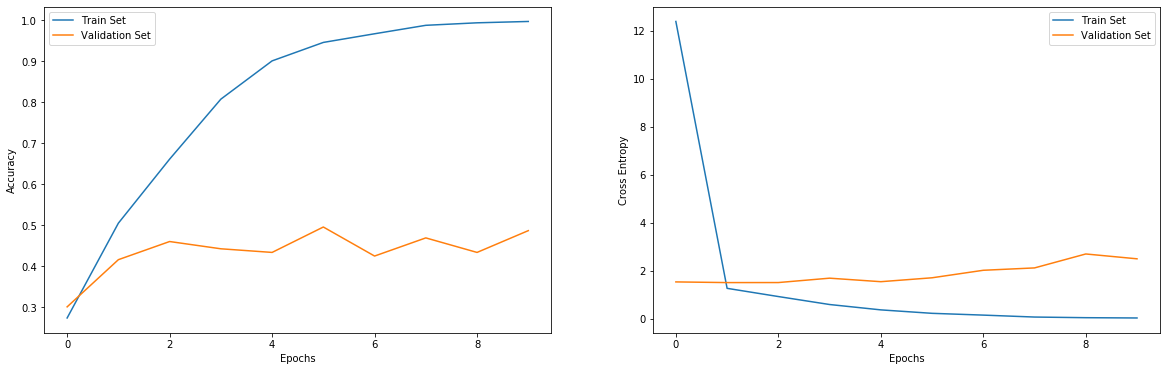

In [7]:
plot_training_curves(train_log)

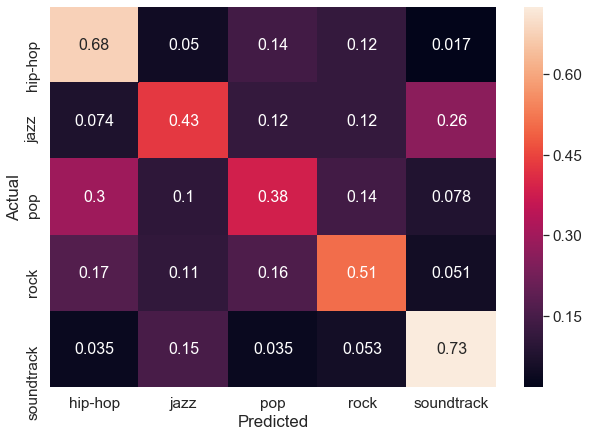

In [8]:
confusion_plot(y_test, y_predict)

From the above graphs, we can conclude that the model is severely overfitting to the data. For CNNs, there are several ways to avoid overfitting such as:

 * Changing the activation functions at the hidden layers.
 * Increasing or decreasing the number of nodes/filters in our hidden layers.
 * Modifying the number of layers in the CNN.
 * Applying regularization techniques (l1, l2, early stopping, etc.) while training the model.
 * Adding more music data.
 
However, there are several issues when trying to prevent overfitting. For example, if we combine the first four examples (see above), it involves finding the best hyperparameters that would give the best accuracy score so it would be a very time consuming process. Moreover, CNN models generally perform best when it is trained on a large dataset. Our dataset is about 2800 samples, so our model trained on that dataset would lead to overfitting.

The question now is, can we achieve a better accuracy using a CNN? For now let's save this base CNN model.

In [18]:
cnn_model.save('cnn_model.hdf5')

## Pretrained Convolutional Neural Network

A pretrained convolutional neural network is basically a neural network that was trained on a very large image dataset (~1,000,000 images). For example, VGG16 is a neural network that was trained for 3 days on a 15,000,000 labelled high resolution image dataset. One of the benefits of using a pretrained network is that it already has the optimal parameters in each CNN layer. This means that you would only need to consider optimizing the hyperparameters in the fully connected layers, i.e you will have fewer hyperparameters to tune.

To see how well pretrained CNNs perform, let's define the architecture, train the model, and see its performance.

#### Pretrained CNN Architecture

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

pretrained_params = {
    'input_shape': (128, 431, 3),
    'include_top': False,
    'weights': 'imagenet'
}
Pretrained_VGG16 = VGG16(**pretrained_params)
Pretrained_VGG16.trainable = False

input_layer = Input(shape=(128, 431, 1))

x = Concatenate()(
    [input_layer, input_layer, input_layer],
)
x = Pretrained_VGG16(x)
x = Flatten()(x)

output_layer = Dense(5, activation='softmax')(x)

pretrained_cnn_model = Model(
    inputs=input_layer, 
    outputs=output_layer, 
)
pretrained_cnn_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
pretrained_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 431, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 431, 3)  0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 4, 13, 512)   14714688    concatenate[0][0]                
______________________________________________________________________________________________

#### Pretrained CNN Training

In [11]:
train_log = pretrained_cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.05)

Epoch 1/10
67/67 [==============================] - 166s 2s/step - loss: 4.0184 - accuracy: 0.4985 - val_loss: 1.8842 - val_accuracy: 0.7080
Epoch 2/10
67/67 [==============================] - 165s 2s/step - loss: 0.5938 - accuracy: 0.8611 - val_loss: 1.4737 - val_accuracy: 0.7257
Epoch 3/10
67/67 [==============================] - 165s 2s/step - loss: 0.1529 - accuracy: 0.9429 - val_loss: 1.8134 - val_accuracy: 0.7080
Epoch 4/10
67/67 [==============================] - 167s 2s/step - loss: 0.0452 - accuracy: 0.9823 - val_loss: 1.6924 - val_accuracy: 0.7611
Epoch 5/10
67/67 [==============================] - 164s 2s/step - loss: 0.0239 - accuracy: 0.9904 - val_loss: 1.6499 - val_accuracy: 0.7522
Epoch 6/10
67/67 [==============================] - 163s 2s/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 1.7834 - val_accuracy: 0.7168
Epoch 7/10
67/67 [==============================] - 163s 2s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.6189 - val_accuracy: 0.6991
Epoch 8/10
67

#### Performance Evaluation For Pretrained CNN

In [12]:
pretrained_cnn_model.evaluate(X_test, y_test)
y_predict = pretrained_cnn_model.predict(X_test)

18/18 [==============================] - 40s 2s/step - loss: 1.2699 - accuracy: 0.7651


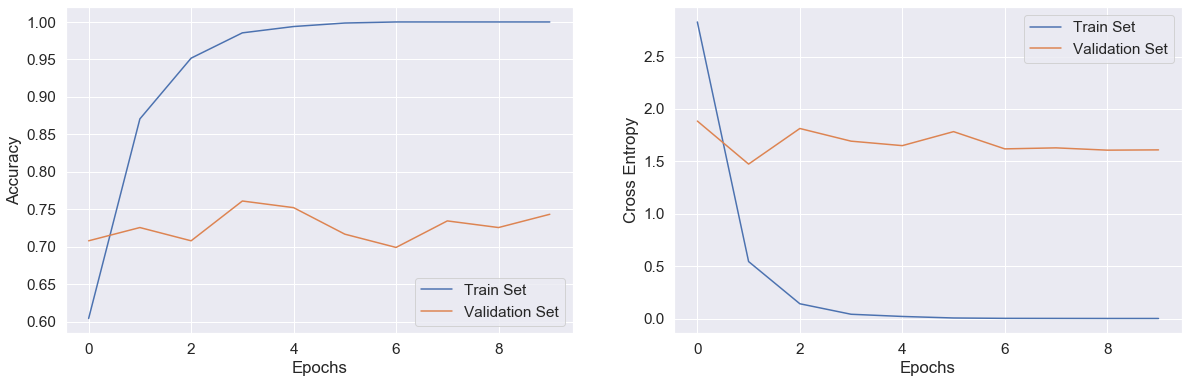

In [13]:
plot_training_curves(train_log)

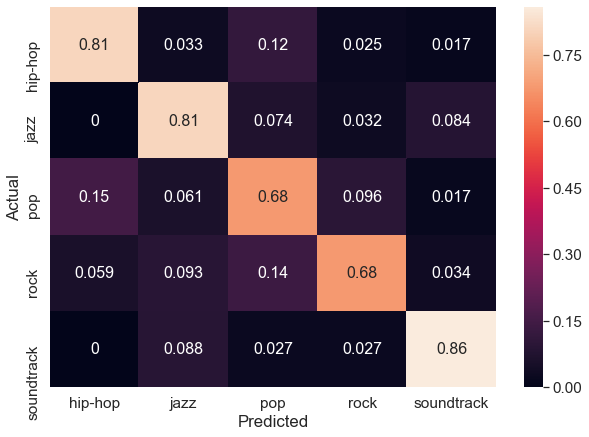

In [14]:
confusion_plot(y_test, y_predict)

Even though VGG16 was trained on high resolution images, not melspectrograms, this model performed really well compared to the base CNN model (by 20% in terms of accuracy). It performed best for hip-hop, jazz, and sountrack music, but it still had issues with pop, and rock music.

In [16]:
pretrained_cnn_model.save('pretrained_cnn_model.hdf5')

## Modified Convolutional Network

In [12]:
#Coming Soon ...

#### Performance Evaluation For Modified CNN

In [13]:
#Coming Soon ...